# CS F425 Deep Learning Project (Group 4) - SBPool Implementation
### Based on: [_Mind the Pool: Convolutional Neural Networks Can Overfit Input Size_](https://openreview.net/pdf?id=cWmtUcsYC3V)

This notebook implements a comparison between Global Average Pooling (GAP) and a simplified version of Spatially Balanced Pooling (SBPool) as the final pooling layer in a MobileNetV2 architecture trained on CIFAR-10.

**Goal:** Replicate the core idea of Figure 1 from the paper, demonstrating how SBPool can mitigate input size overfitting compared to standard GAP, using MobileNetV2 and CIFAR-10.

**Methodology:**
1. Load CIFAR-10 dataset.
2. Implement a `SpatiallyBalancedPooling` layer (acting as a replacement for GAP).
3. Define a function to build a MobileNetV2 model with either GAP or SBPool, **ensuring flexible input spatial dimensions (`None, None, 3`)**.
4. **Train two models (from scratch) on CIFAR-10 images resized to 224x224:**
   - One using GAP.
   - One using SBPool.
5. **Evaluate both trained models on the CIFAR-10 test set resized to various input sizes (24x24 to 96x96).**
6. Plot the accuracy vs. input size for both models to compare their sensitivity.

## 1. Setup and Imports

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications, utils
import numpy as np
import matplotlib.pyplot as plt
import time

# Ensure TensorFlow can see the GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if len(tf.config.experimental.list_physical_devices('GPU')) > 0:
    print("Using GPU")
    # Optional: Allocate memory dynamically
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("!!! Using CPU - Training will be very slow !!!")

# --- Configuration ---
TRAIN_IMG_SIZE = 32 # Target size for training images (as per paper's common size)
EVAL_MIN_SIZE = 24  # Start evaluation range
EVAL_MAX_SIZE = 96  # End evaluation range
BATCH_SIZE = 64 # Reduce if OOM errors occur during training
EPOCHS = 30      # Increase for better accuracy
BUFFER_SIZE = 1000 # For shuffling training data
SBPOOL_GRID_SIZE = 4 # Grid size for SBPool layer

Num GPUs Available:  1
Using GPU


## 2. Load and Preprocess CIFAR-10 Dataset

In [9]:
# Loading the CIFAR-10 dataset:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# One-hot encode labels
y_train = utils.to_categorical(y_train, 10)
y_test = utils.to_categorical(y_test, 10)

print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")

# Create tf.data pipelines for resizing during training/validation

def preprocess_image(image, label, target_size):
    # Resize the image
    image = tf.image.resize(image, [target_size, target_size])
    return image, label

# Training Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(lambda img, lbl: preprocess_image(img, lbl, TRAIN_IMG_SIZE),
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

# Validation Dataset (using test set, resized to the training size for validation during fit)
val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.map(lambda img, lbl: preprocess_image(img, lbl, TRAIN_IMG_SIZE),
                                num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

print(f"\nCreated tf.data pipelines.")
print(f"Training images will be resized to: {TRAIN_IMG_SIZE}x{TRAIN_IMG_SIZE}")

Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 10)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 10)

Created tf.data pipelines.
Training images will be resized to: 32x32


## 3. Implement Spatially Balanced Pooling Layer

This implementation acts as a *replacement for Global Average Pooling*. It divides the feature map into a grid and samples one feature vector from the center of each grid cell, then averages these samples.

**Note:** This is a simplification. The original paper's SBPool modifies intermediate downsampling layers (MaxPool, Strided Conv) by randomizing padding during training to make them less sensitive to exact input dimensions and boundary conditions. Implementing that is more complex and requires modifying the MobileNetV2 architecture internally or wrapping its layers.

In [10]:
class SpatiallyBalancedPooling(tf.keras.layers.Layer):
    """Spatially Balanced Pooling layer (Simplified, replaces Global Average Pooling).

    Divides the input feature map into a grid, takes a sample from the center
    of each grid cell using tf.gather_nd (vectorized), and averages the samples.

    Args:
        grid_size (int): The number of cells along each spatial dimension.
        **kwargs: Standard Keras layer keyword arguments.
    """
    def __init__(self, grid_size=4, **kwargs):
        super().__init__(**kwargs)
        if not isinstance(grid_size, int) or grid_size <= 0:
            raise ValueError("grid_size must be a positive integer.")
        self.grid_size = grid_size

    def call(self, x):
        # Get dynamic shape components
        input_shape = tf.shape(x)
        B = input_shape[0]
        H = input_shape[1]
        W = input_shape[2]
        C = input_shape[3]

        # Handle cases where input spatial dimensions might be smaller than grid size
        eff_grid_size_h = tf.minimum(self.grid_size, H)
        eff_grid_size_w = tf.minimum(self.grid_size, W)

        # Calculate grid cell dimensions (integer division)
        grid_h = tf.maximum(1, H // eff_grid_size_h)
        grid_w = tf.maximum(1, W // eff_grid_size_w)

        # --- Vectorized calculation of center indices ---
        # !!! UNCOMMENTED THESE LINES !!!
        i_coords = tf.range(eff_grid_size_h) # 0 to grid_size_h - 1
        j_coords = tf.range(eff_grid_size_w) # 0 to grid_size_w - 1
        ii, jj = tf.meshgrid(i_coords, j_coords, indexing='ij')

        h_start = ii * grid_h
        w_start = jj * grid_w

        cy = h_start + (grid_h // 2)
        cx = w_start + (grid_w // 2)

        # Flatten the grid coordinates
        cy_flat = tf.reshape(cy, [-1])
        cx_flat = tf.reshape(cx, [-1])

        # Create batch indices
        batch_indices = tf.range(B)
        batch_indices_exp = tf.expand_dims(batch_indices, axis=1)

        # Tile to create combinations
        num_centers = eff_grid_size_h * eff_grid_size_w
        batch_indices_tiled = tf.tile(batch_indices_exp, [1, num_centers])
        cy_tiled = tf.tile(tf.expand_dims(cy_flat, axis=0), [B, 1])
        cx_tiled = tf.tile(tf.expand_dims(cx_flat, axis=0), [B, 1])

        # Stack indices: (B, num_centers, 3)
        indices = tf.stack([batch_indices_tiled, cy_tiled, cx_tiled], axis=-1)

        # Gather the samples: (B, num_centers, C)
        samples = tf.gather_nd(x, indices)

        # Compute the mean across the samples (axis=1): (B, C)
        pooled = tf.reduce_mean(samples, axis=1)

        return pooled

    def compute_output_shape(self, input_shape):
        if isinstance(input_shape, tf.TensorShape):
            input_shape = input_shape.as_list()
        if input_shape[3] is None:
             return tf.TensorShape([input_shape[0], None])
        else:
             return (input_shape[0], input_shape[3])

    def get_config(self):
        config = super().get_config()
        config.update({
            "grid_size": self.grid_size,
        })
        return config

## 4. Build MobileNetV2 Models

**Correction:** Models are now built with `input_shape=(None, None, 3)` to allow variable spatial dimensions during evaluation.

In [11]:
def build_mobilenet(pooling_type='gap', input_shape=(None, None, 3)): # Changed H, W to None
    """Builds a MobileNetV2 model for CIFAR-10 with specified pooling.
       Allows for variable input spatial dimensions.

    Args:
        pooling_type (str): 'gap' for GlobalAveragePooling2D or 'sbp' for SpatiallyBalancedPooling.
        input_shape (tuple): The input shape for the model. Use (None, None, 3) for variable size.

    Returns:
        tf.keras.Model: The compiled Keras model.
    """
    # Define the input layer explicitly with flexible dimensions
    img_input = layers.Input(shape=input_shape, name='input_image')

    # Load MobileNetV2 base, excluding the top classification layer
    base = applications.MobileNetV2(
        include_top=False,
        weights=None, # Crucial: Train from scratch
        input_tensor=img_input, # Pass the flexible input tensor
        pooling=None # We will add our own pooling layer
    )

    # Get the output of the base model
    x = base.output

    # Add the specified pooling layer
    if pooling_type == 'gap':
        x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
    elif pooling_type == 'sbp':
        # Ensure the SBPool class definition has been executed
        x = SpatiallyBalancedPooling(grid_size=SBPOOL_GRID_SIZE, name='sb_pool')(x)
    else:
        raise ValueError(f"Unknown pooling_type: {pooling_type}. Use 'gap' or 'sbp'.")

    # Add the final classification layer for CIFAR-10 (10 classes)
    output = layers.Dense(10, activation='softmax', name='predictions')(x)

    # Create the model using the explicitly defined input
    model = models.Model(inputs=img_input, outputs=output)

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# --- Build the models ---# IMPORTANT: Must re-run this cell if you changed the build_mobilenet function definition
print("Building models with flexible input shape (None, None, 3)...")

# Build the models with flexible input shape
model_gap = build_mobilenet(pooling_type='gap', input_shape=(None, None, 3))
print("\n--- GAP Model Summary (Flexible Input) ---")
model_gap.summary()

model_sbp = build_mobilenet(pooling_type='sbp', input_shape=(None, None, 3))
print("\n--- SBPool Model Summary (Flexible Input) ---")
model_sbp.summary()


Building models with flexible input shape (None, None, 3)...

--- GAP Model Summary (Flexible Input) ---


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, None, None, 32) │            864 │ input_image[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, None, None, 32) │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, None, None, 32) │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, None, None, 32) │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, None, None, 32) │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, None, None, 32) │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, None, None, 16) │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, None, None, 16) │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, None, None, 96) │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, None, None, 96) │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, None, None, 96) │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, None, None, 96) │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, None, None, 96) │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 2,236,682 (8.53 MB)

 Non-trainable params: 34,112 (133.25 KB)


--- SBPool Model Summary (Flexible Input) ---


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, None, None, 32) │            864 │ input_image[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, None, None, 32) │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, None, None, 32) │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, None, None, 32) │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, None, None, 32) │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, None, None, 32) │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, None, None, 16) │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, None, None, 16) │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, None, None, 96) │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, None, None, 96) │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, None, None, 96) │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, None, None, 96) │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, None, None, 96) │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 2,236,682 (8.53 MB)

 Non-trainable params: 34,112 (133.25 KB)

## 5. Train Models

**Warning:** Training MobileNetV2 from scratch on 224x224 images is computationally intensive, even on a GPU. Training for only a few epochs (`EPOCHS=5`) will likely result in low accuracy, but should be sufficient to observe the *relative* sensitivity difference between GAP and SBPool during evaluation. Increase `EPOCHS` significantly (e.g., 30-50+) for better absolute performance, but expect long training times.

**Note:** Since the model building function was corrected, these training cells need to be re-run.

In [12]:
# Define filenames
gap_model_filename = 'model_gap_cifar10_224_trained_flexible.keras' # Adjusted filename


print(f"\n--- Training GAP Model for {EPOCHS} epochs (Input: {TRAIN_IMG_SIZE}x{TRAIN_IMG_SIZE}) ---")
start_time = time.time()
history_gap = model_gap.fit(
    train_dataset, # Uses TRAIN_IMG_SIZE (224x224)
    epochs=EPOCHS,
    validation_data=val_dataset, # Uses TRAIN_IMG_SIZE (224x224)
    verbose=1
)
gap_train_time = time.time() - start_time
print(f"GAP Model training finished in {gap_train_time:.2f} seconds.")

# Save the GAP model
print("\n--- Saving Trained GAP Model ---")

try:
    model_gap.save(gap_model_filename)
    print(f"Successfully saved GAP model to {gap_model_filename}")
except Exception as e:
    print(f"Error saving GAP model: {e}")


--- Training GAP Model for 30 epochs (Input: 32x32) ---
Epoch 1/30


I0000 00:00:1744648107.841087      89 service.cc:148] XLA service 0x7ee540003090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744648107.841812      89 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744648110.966662      89 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1744648114.213037      89 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744648114.386019      89 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744648114.715683      89 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744648114.9004

  8/782 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.1164 - loss: 2.8190  

I0000 00:00:1744648124.148536      89 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


779/782 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2286 - loss: 2.1765

E0000 00:00:1744648140.609700      88 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744648140.781528      88 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744648141.098638      88 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744648141.281493      88 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


782/782 ━━━━━━━━━━━━━━━━━━━━ 83s 41ms/step - accuracy: 0.2290 - loss: 2.1751 - val_accuracy: 0.1000 - val_loss: 2.3125
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.4225 - loss: 1.5843 - val_accuracy: 0.1000 - val_loss: 2.3474
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.4843 - loss: 1.4475 - val_accuracy: 0.1000 - val_loss: 2.3334
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.5219 - loss: 1.3519 - val_accuracy: 0.1000 - val_loss: 2.3645
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.5658 - loss: 1.2334 - val_accuracy: 0.1000 - val_loss: 2.3759
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.5786 - loss: 1.2103 - val_accuracy: 0.3859 - val_loss: 1.7847
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.6006 - loss: 1.1338 - val_accuracy: 0.1152 - val_loss: 4.2636
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.5325 - loss: 1.3548 - val_accurac

In [13]:
# Define filename
sbp_model_filename = 'model_sbp_cifar10_224_trained_flexible.keras' # Adjusted filename


print(f"\n--- Training SBPool Model for {EPOCHS} epochs (Input: {TRAIN_IMG_SIZE}x{TRAIN_IMG_SIZE}) ---")
start_time = time.time()
history_sbp = model_sbp.fit(
    train_dataset, # Uses TRAIN_IMG_SIZE (224x224)
    epochs=EPOCHS,
    validation_data=val_dataset, # Uses TRAIN_IMG_SIZE (224x224)
    verbose=1
)
sbp_train_time = time.time() - start_time
print(f"SBPool Model training finished in {sbp_train_time:.2f} seconds.")


# Save the SBPool model
print("\n--- Saving Trained SBPool Model ---")

try:
    model_sbp.save(sbp_model_filename)
    print(f"Successfully saved SBPool model to {sbp_model_filename}")
except Exception as e:
    print(f"Error saving SBPool model: {e}")


--- Training SBPool Model for 30 epochs (Input: 32x32) ---
Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 77s 39ms/step - accuracy: 0.2517 - loss: 2.0803 - val_accuracy: 0.1000 - val_loss: 2.3370
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.4258 - loss: 1.5880 - val_accuracy: 0.1000 - val_loss: 2.3400
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.4614 - loss: 1.5126 - val_accuracy: 0.1000 - val_loss: 2.3510
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.5101 - loss: 1.3685 - val_accuracy: 0.1000 - val_loss: 2.4276
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.5074 - loss: 1.4078 - val_accuracy: 0.1619 - val_loss: 2.2457
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.5269 - loss: 1.3408 - val_accuracy: 0.2310 - val_loss: 1.9645
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.5788 - loss: 1.2079 - val_accuracy: 0.1647 - val_loss: 4.1763
Epoch 8/30
782/782 ━━━━━━━━━━━

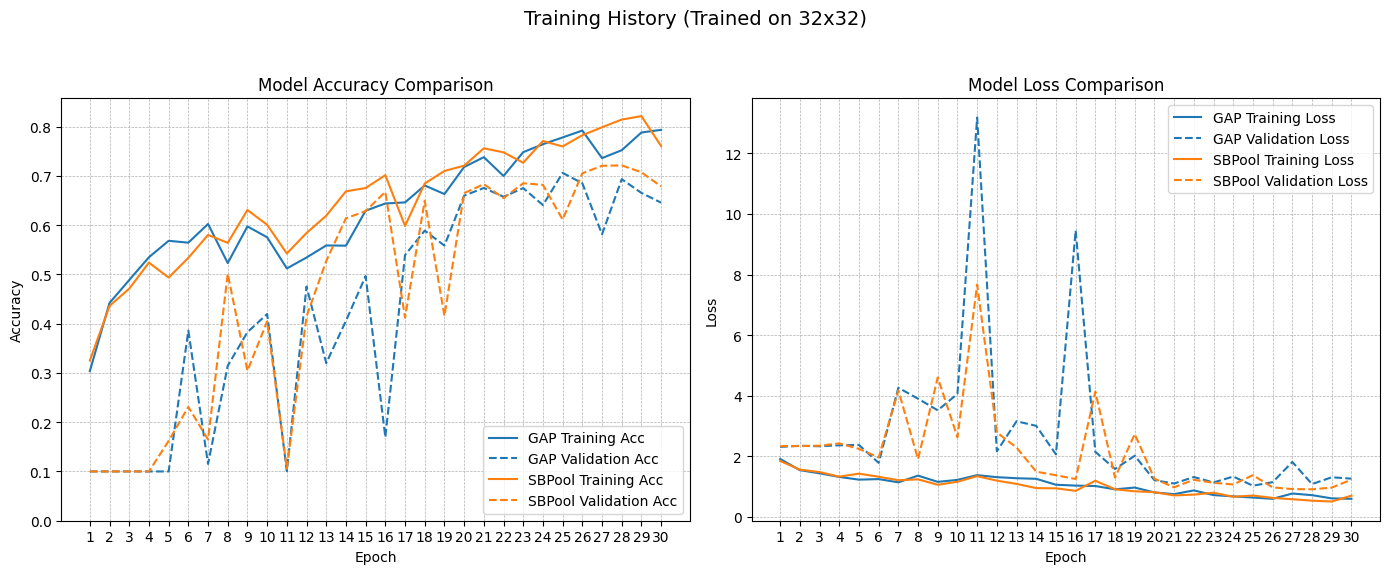

In [14]:
# Make sure history_gap and history_sbp variables exist from the training cells
# Assumes EPOCHS variable is still correctly defined from the configuration cell

# Check if history objects exist and have data
history_exists_gap = 'history_gap' in locals() and hasattr(history_gap, 'history') and history_gap.history
history_exists_sbp = 'history_sbp' in locals() and hasattr(history_sbp, 'history') and history_sbp.history

if not history_exists_gap and not history_exists_sbp:
    print("History objects not found. Please ensure the models were trained in this session.")
else:
    # Determine the number of epochs actually trained (in case it finished early)
    # Use the minimum epochs completed by either model if both exist
    epochs_trained_gap = len(history_gap.history['loss']) if history_exists_gap else 0
    epochs_trained_sbp = len(history_sbp.history['loss']) if history_exists_sbp else 0
    actual_epochs = max(epochs_trained_gap, epochs_trained_sbp) # Use max length found
    
    if actual_epochs == 0:
         print("History objects found but contain no epoch data. Cannot plot.")
    else:
        epochs_range = range(1, actual_epochs + 1)

        plt.figure(figsize=(14, 6))

        #--------------------
        # Accuracy Plot
        #--------------------
        plt.subplot(1, 2, 1)
        if history_exists_gap and 'accuracy' in history_gap.history and 'val_accuracy' in history_gap.history:
            plt.plot(epochs_range, history_gap.history['accuracy'], label='GAP Training Acc', color='tab:blue', linestyle='-')
            plt.plot(epochs_range, history_gap.history['val_accuracy'], label='GAP Validation Acc', color='tab:blue', linestyle='--')
        if history_exists_sbp and 'accuracy' in history_sbp.history and 'val_accuracy' in history_sbp.history:
             # Make sure history_sbp has enough epochs if training stopped early for one model
            epochs_sbp = range(1, len(history_sbp.history['accuracy']) + 1)
            plt.plot(epochs_sbp, history_sbp.history['accuracy'], label='SBPool Training Acc', color='tab:orange', linestyle='-')
            plt.plot(epochs_sbp, history_sbp.history['val_accuracy'], label='SBPool Validation Acc', color='tab:orange', linestyle='--')
        
        plt.title('Model Accuracy Comparison')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.ylim(bottom=0) # Start accuracy axis at 0
        plt.xticks(epochs_range) # Ensure integer ticks for epochs if range is small
        plt.legend(loc='lower right')
        plt.grid(True, linestyle='--', linewidth=0.5)

        #--------------------
        # Loss Plot
        #--------------------
        plt.subplot(1, 2, 2)
        if history_exists_gap and 'loss' in history_gap.history and 'val_loss' in history_gap.history:
            plt.plot(epochs_range, history_gap.history['loss'], label='GAP Training Loss', color='tab:blue', linestyle='-')
            plt.plot(epochs_range, history_gap.history['val_loss'], label='GAP Validation Loss', color='tab:blue', linestyle='--')
        if history_exists_sbp and 'loss' in history_sbp.history and 'val_loss' in history_sbp.history:
            epochs_sbp = range(1, len(history_sbp.history['loss']) + 1)
            plt.plot(epochs_sbp, history_sbp.history['loss'], label='SBPool Training Loss', color='tab:orange', linestyle='-')
            plt.plot(epochs_sbp, history_sbp.history['val_loss'], label='SBPool Validation Loss', color='tab:orange', linestyle='--')

        plt.title('Model Loss Comparison')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.xticks(epochs_range)
        plt.legend(loc='upper right')
        plt.grid(True, linestyle='--', linewidth=0.5)

        plt.suptitle(f'Training History (Trained on {TRAIN_IMG_SIZE}x{TRAIN_IMG_SIZE})', fontsize=14)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent suptitle overlap
        plt.show()

## 6. Evaluate Models on Varying Input Sizes

Now that the models are built with flexible input shapes `(None, None, 3)`, this evaluation loop should work correctly, accepting images resized from 192x192 up to 298x298.

In [15]:
# Optional: Load models if session was interrupted AFTER saving the *flexible* models
LOAD_SAVED_MODELS = False # Set to True to load instead of using trained models in memory

if LOAD_SAVED_MODELS:
    print("--- Loading Pre-Trained Flexible Models ---")
    gap_model_filename = '/kaggle/input/dlproject/keras/default/1/model_gap_cifar10_224_trained_flexible.keras'
    sbp_model_filename = '/kaggle/input/dlproject/keras/default/1/model_sbp_cifar10_224_trained_flexible.keras'
    try:
        custom_objects = {'SpatiallyBalancedPooling': SpatiallyBalancedPooling}
        model_gap = tf.keras.models.load_model(gap_model_filename)
        print(f"Successfully loaded GAP model from {gap_model_filename}")
        model_sbp = tf.keras.models.load_model(sbp_model_filename, custom_objects=custom_objects)
        print(f"Successfully loaded SBPool model from {sbp_model_filename}")
        print("Models loaded successfully.")
    except Exception as e:
        print(f"Error loading models: {e}")
        print("Ensure the correct .keras files are uploaded and run training first if files not found.")
        # Set models to None or raise error to prevent evaluating incorrect models
        model_gap = None
        model_sbp = None
else:
    print("--- Using models trained in the current session ---")


--- Using models trained in the current session ---


In [16]:
# Evaluation

def evaluate_on_sizes(model, model_name, x_test_orig, y_test_orig, min_size, max_size):
    """Evaluates a model on test data resized to various sizes using tf.data."""
    if model is None:
        print(f"Model {model_name} is not available for evaluation. Skipping.")
        return [], []

    sizes = list(range(min_size, max_size + 1))
    accuracies = []
    print(f"\nEvaluating model '{model_name}' from size {min_size} to {max_size}...")
    start_eval_time = time.time()

    # Original test data as a tf.data.Dataset (without resizing yet)
    base_test_dataset = tf.data.Dataset.from_tensor_slices((x_test_orig, y_test_orig))

    for i, size in enumerate(sizes):
        # --- Create a NEW dataset for this specific size ---
        # Map the resize function for the current 'size'
        def resize_for_eval(image, label):
             # Use tf.cast inside the map function
            image = tf.cast(image, tf.float32)
            image = tf.image.resize(image, [size, size])
            return image, label

        # Apply the mapping and batching
        eval_dataset = base_test_dataset.map(resize_for_eval, num_parallel_calls=tf.data.AUTOTUNE)
        eval_dataset = eval_dataset.batch(BATCH_SIZE * 2) # Use larger batch for faster eval
        eval_dataset = eval_dataset.prefetch(tf.data.AUTOTUNE)
        # ---------------------------------------------------

        # Evaluate the model using the prepared dataset for this size
        try:
            # Pass the dataset directly to evaluate
            loss, acc = model.evaluate(eval_dataset, verbose=0)
            accuracies.append(acc)
        except tf.errors.ResourceExhaustedError as e:
            # This might still happen if a *single batch* at a large size + model activations is too big
            print(f"  OOM Error evaluating size {size}x{size}. Appending NaN. Consider reducing evaluation BATCH_SIZE if persistent.")
            accuracies.append(np.nan) # Append NaN to indicate failure
            # Optionally break or continue
            # break

        if (i + 1) % 10 == 0 or i == len(sizes) - 1:
            # Handle potential NaN when printing
            current_acc_val = accuracies[-1]
            acc_str = 'NaN (OOM)' if np.isnan(current_acc_val) else f'{current_acc_val:.4f}'
            print(f"  Evaluated up to size {size}x{size}... Accuracy: {acc_str}")

    end_eval_time = time.time()
    print(f"Evaluation finished in {end_eval_time - start_eval_time:.2f} seconds.")
    return sizes, accuracies

# --- You will call this function after the fix ---
if model_gap and model_sbp:
    eval_sizes_gap, acc_gap = evaluate_on_sizes(model_gap, "GAP Model", x_test, y_test, EVAL_MIN_SIZE, EVAL_MAX_SIZE)
    eval_sizes_sbp, acc_sbp = evaluate_on_sizes(model_sbp, "SBPool Model", x_test, y_test, EVAL_MIN_SIZE, EVAL_MAX_SIZE)
else:
    print("Models not available for evaluation.")


Evaluating model 'GAP Model' from size 24 to 96...
  Evaluated up to size 33x33... Accuracy: 0.6078
  Evaluated up to size 43x43... Accuracy: 0.3338
  Evaluated up to size 53x53... Accuracy: 0.1472
  Evaluated up to size 63x63... Accuracy: 0.1630
  Evaluated up to size 73x73... Accuracy: 0.1428
  Evaluated up to size 83x83... Accuracy: 0.1070
  Evaluated up to size 93x93... Accuracy: 0.1071
  Evaluated up to size 96x96... Accuracy: 0.1234
Evaluation finished in 296.41 seconds.

Evaluating model 'SBPool Model' from size 24 to 96...
  Evaluated up to size 33x33... Accuracy: 0.5855
  Evaluated up to size 43x43... Accuracy: 0.2697
  Evaluated up to size 53x53... Accuracy: 0.1392
  Evaluated up to size 63x63... Accuracy: 0.1356
  Evaluated up to size 73x73... Accuracy: 0.1393
  Evaluated up to size 83x83... Accuracy: 0.1273
  Evaluated up to size 93x93... Accuracy: 0.1273
  Evaluated up to size 96x96... Accuracy: 0.1399
Evaluation finished in 280.46 seconds.


## 7. Plot Results

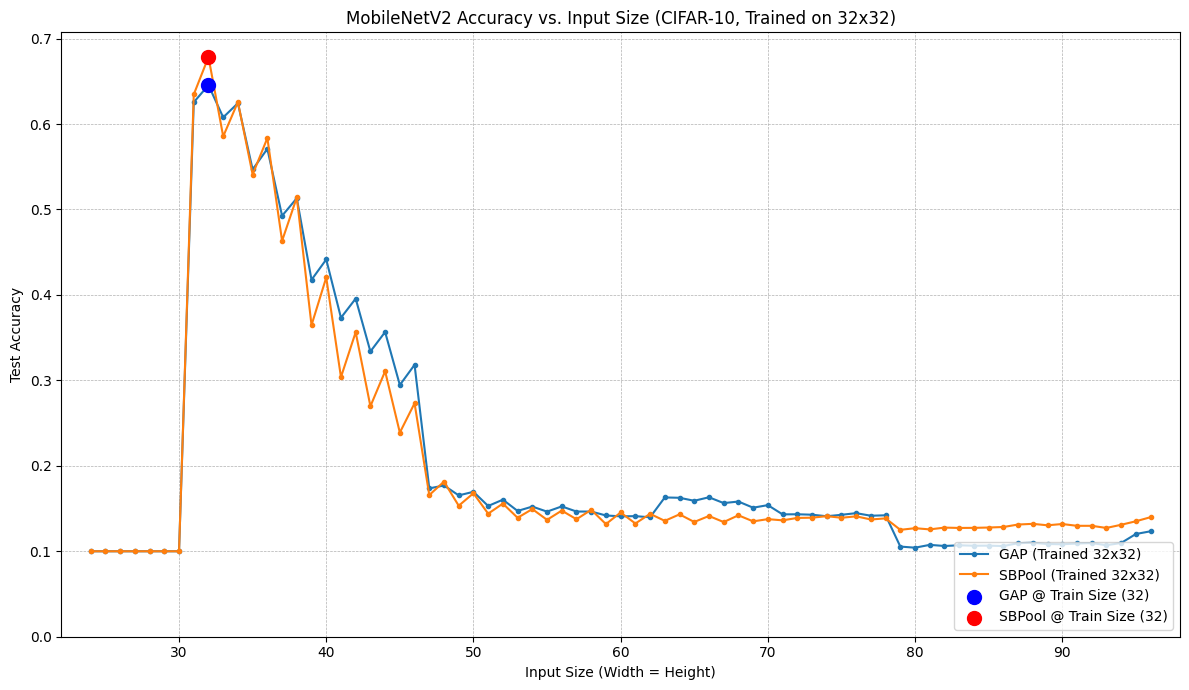

--- Accuracy Summary ---
Training Size: 32x32
Accuracy at 32x32:
  GAP:    0.6455
  SBPool: 0.6784

Accuracy at 24x24 (Min Eval Size):
  GAP:    0.1000
  SBPool: 0.1000

Accuracy at 96x96 (Max Eval Size):
  GAP:    0.1234
  SBPool: 0.1399


In [17]:
plt.figure(figsize=(12, 7))

# Filter out NaN values for plotting if OOM occurred
valid_indices_gap = [i for i, acc in enumerate(acc_gap) if not np.isnan(acc)]
valid_indices_sbp = [i for i, acc in enumerate(acc_sbp) if not np.isnan(acc)]

if valid_indices_gap:
    plt.plot([eval_sizes_gap[i] for i in valid_indices_gap],
             [acc_gap[i] for i in valid_indices_gap],
             label=f'GAP (Trained {TRAIN_IMG_SIZE}x{TRAIN_IMG_SIZE})', marker='.', linestyle='-')
if valid_indices_sbp:
    plt.plot([eval_sizes_sbp[i] for i in valid_indices_sbp],
             [acc_sbp[i] for i in valid_indices_sbp],
             label=f'SBPool (Trained {TRAIN_IMG_SIZE}x{TRAIN_IMG_SIZE})', marker='.', linestyle='-')

# Highlight the training size
if TRAIN_IMG_SIZE in eval_sizes_gap and not np.isnan(acc_gap[eval_sizes_gap.index(TRAIN_IMG_SIZE)]):
    train_idx = eval_sizes_gap.index(TRAIN_IMG_SIZE)
    plt.scatter(eval_sizes_gap[train_idx], acc_gap[train_idx], color='blue', s=100, zorder=5, label=f'GAP @ Train Size ({TRAIN_IMG_SIZE})')
if TRAIN_IMG_SIZE in eval_sizes_sbp and not np.isnan(acc_sbp[eval_sizes_sbp.index(TRAIN_IMG_SIZE)]):
    train_idx = eval_sizes_sbp.index(TRAIN_IMG_SIZE)
    plt.scatter(eval_sizes_sbp[train_idx], acc_sbp[train_idx], color='red', s=100, zorder=5, label=f'SBPool @ Train Size ({TRAIN_IMG_SIZE})')

plt.title(f'MobileNetV2 Accuracy vs. Input Size (CIFAR-10, Trained on {TRAIN_IMG_SIZE}x{TRAIN_IMG_SIZE})')
plt.xlabel('Input Size (Width = Height)')
plt.ylabel('Test Accuracy')
plt.legend(loc='lower right')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylim(bottom=0) # Start y-axis at 0
plt.xlim(EVAL_MIN_SIZE - 2, EVAL_MAX_SIZE + 2)
plt.tight_layout()
plt.show()

# Print final accuracies at specific points for comparison
print("--- Accuracy Summary ---")
print(f"Training Size: {TRAIN_IMG_SIZE}x{TRAIN_IMG_SIZE}")
try:
    train_idx_gap = eval_sizes_gap.index(TRAIN_IMG_SIZE)
    acc_train_gap = acc_gap[train_idx_gap] if not np.isnan(acc_gap[train_idx_gap]) else 'NaN (OOM)'
    train_idx_sbp = eval_sizes_sbp.index(TRAIN_IMG_SIZE)
    acc_train_sbp = acc_sbp[train_idx_sbp] if not np.isnan(acc_sbp[train_idx_sbp]) else 'NaN (OOM)'
    print(f"Accuracy at {TRAIN_IMG_SIZE}x{TRAIN_IMG_SIZE}:")
    print(f"  GAP:    {acc_train_gap if isinstance(acc_train_gap, str) else f'{acc_train_gap:.4f}'}")
    print(f"  SBPool: {acc_train_sbp if isinstance(acc_train_sbp, str) else f'{acc_train_sbp:.4f}'}")
except (ValueError, IndexError): # Handle if TRAIN_IMG_SIZE was outside eval range
    print(f"Accuracy at {TRAIN_IMG_SIZE}x{TRAIN_IMG_SIZE}: Not evaluated.")

try:
    min_idx_gap = eval_sizes_gap.index(EVAL_MIN_SIZE)
    acc_min_gap = acc_gap[min_idx_gap] if not np.isnan(acc_gap[min_idx_gap]) else 'NaN (OOM)'
    min_idx_sbp = eval_sizes_sbp.index(EVAL_MIN_SIZE)
    acc_min_sbp = acc_sbp[min_idx_sbp] if not np.isnan(acc_sbp[min_idx_sbp]) else 'NaN (OOM)'
    print(f"\nAccuracy at {EVAL_MIN_SIZE}x{EVAL_MIN_SIZE} (Min Eval Size):")
    print(f"  GAP:    {acc_min_gap if isinstance(acc_min_gap, str) else f'{acc_min_gap:.4f}'}")
    print(f"  SBPool: {acc_min_sbp if isinstance(acc_min_sbp, str) else f'{acc_min_sbp:.4f}'}")
except (ValueError, IndexError):
    print(f"Accuracy at {EVAL_MIN_SIZE}x{EVAL_MIN_SIZE}: Not evaluated.")

try:
    max_idx_gap = eval_sizes_gap.index(EVAL_MAX_SIZE)
    acc_max_gap = acc_gap[max_idx_gap] if not np.isnan(acc_gap[max_idx_gap]) else 'NaN (OOM)'
    max_idx_sbp = eval_sizes_sbp.index(EVAL_MAX_SIZE)
    acc_max_sbp = acc_sbp[max_idx_sbp] if not np.isnan(acc_sbp[max_idx_sbp]) else 'NaN (OOM)'
    print(f"\nAccuracy at {EVAL_MAX_SIZE}x{EVAL_MAX_SIZE} (Max Eval Size):")
    print(f"  GAP:    {acc_max_gap if isinstance(acc_max_gap, str) else f'{acc_max_gap:.4f}'}")
    print(f"  SBPool: {acc_max_sbp if isinstance(acc_max_sbp, str) else f'{acc_max_sbp:.4f}'}")
except (ValueError, IndexError):
     print(f"Accuracy at {EVAL_MAX_SIZE}x{EVAL_MAX_SIZE}: Not evaluated.")

## 8. Conclusion

The plot above compares the test accuracy of the two MobileNetV2 models (one ending with Global Average Pooling, one with our simplified Spatially Balanced Pooling) when evaluated on CIFAR-10 test images resized to various sizes (from 24x24 up to 96x96).

**Expected Observation (if training was sufficient):**
Similar to Figure 1 in the "Mind the Pool" paper, we expect to see that:
- The accuracy of both models might generally increase or fluctuate as input size changes.
- The **GAP model's accuracy might show more pronounced dips or oscillations**, potentially being more sensitive to specific input sizes, especially those deviating significantly from the training size (32x32) or those that interact differently with the fixed downsampling strides in MobileNetV2.
- The **SBPool model's accuracy curve should ideally be smoother and potentially maintain higher accuracy** across a wider range of input sizes compared to GAP, indicating better robustness to input size variations.

**Note:** Due to the short training time (`EPOCHS=30`), the absolute accuracy will be low, and the difference between the models might be less dramatic than in the original paper. However, the *trend* of SBPool being less sensitive to input size variations might still be observable.